In [1]:
import pandas as pd
import numpy as np
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns


from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC

import pickle

import warnings

In [2]:
df = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=932&path=url_spam.csv')
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [3]:
df.shape

(2999, 2)

In [4]:
df["is_spam"] = df["is_spam"].astype(int)

df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [5]:
df = df.drop_duplicates()
df = df.reset_index(inplace = False, drop = True)
df.shape

(2369, 2)

In [6]:
def preprocess_text(text):
    # Eliminar https, www y dominios
    text = re.sub(r'https?://', " ", text)
    text = re.sub(r'www\.', ' ', text)
    text = re.sub(r'\.(com|net|org|es)', " ", text)

    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)

    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

In [7]:
df["url"] = df["url"].apply(preprocess_text)
df.head()

,url,is_spam
0,"[briefingday, us, list, manage, unsubscribe]",1
1,[hvper],1
2,"[briefingday, v, i]",1
3,"[briefingday, m, commentform]",0
4,"[briefingday, fan]",1


#### Lematización

In [8]:
# instancia lematizador
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    # lematiza
    tokens = [lemmatizer.lemmatize(word) for word in words]
    # saca stop words
    tokens = [word for word in tokens if word not in stop_words]
    # se queda con las de largo mayor a
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df["url"] = df["url"].apply(lemmatize_text)
df.head()

,url,is_spam
0,"[briefingday, list, manage, unsubscribe]",1
1,[hvper],1
2,[briefingday],1
3,"[briefingday, commentform]",0
4,[briefingday],1


#### Vectorizar

In [10]:
tokens_list = df["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 538))

#### Modelo SVM

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
model = SVC(kernel = "linear", random_state = 42)

model.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [13]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [14]:
accuracy_score(y_test, y_pred)

0.9514767932489452

Text(0.5, 1.0, 'Matriz de confusión')

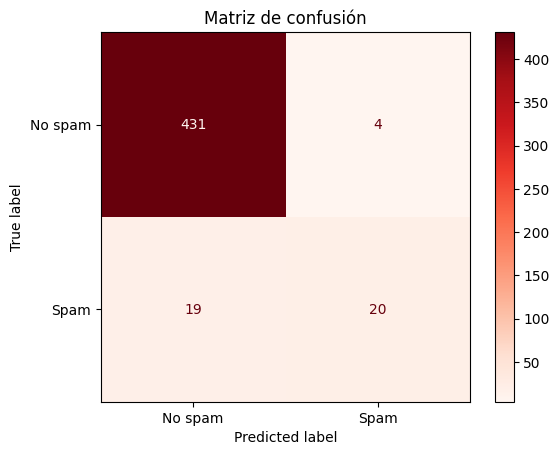

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No spam', 'Spam'])
disp.plot(cmap = 'Reds')
plt.title("Matriz de confusión")


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       435
           1       0.83      0.51      0.63        39

    accuracy                           0.95       474
   macro avg       0.90      0.75      0.80       474
weighted avg       0.95      0.95      0.95       474



La detección de spam real (recall de clase 1) es casi al azar (0.51)

#### Regularización

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir el modelo base
svm = SVC()

# Definir el grid de hiperparámetros
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4]  # solo afecta a kernel="poly"
}

# Crear búsqueda en grid
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,  
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

# Ajustar al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor accuracy en CV:", grid_search.best_score_)



Fitting 5 folds for each of 72 candidates, totalling 360 fits


[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.6s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.3s
[CV] END ..........C=0.1, de

In [18]:
model2 = SVC(C=10, degree=2, gamma= 'scale',  kernel = "poly", random_state = 42)

model2.fit(X_train, y_train)

,C,10
,kernel,'poly'
,degree,2
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       435
           1       0.71      0.69      0.70        39

    accuracy                           0.95       474
   macro avg       0.84      0.83      0.84       474
weighted avg       0.95      0.95      0.95       474



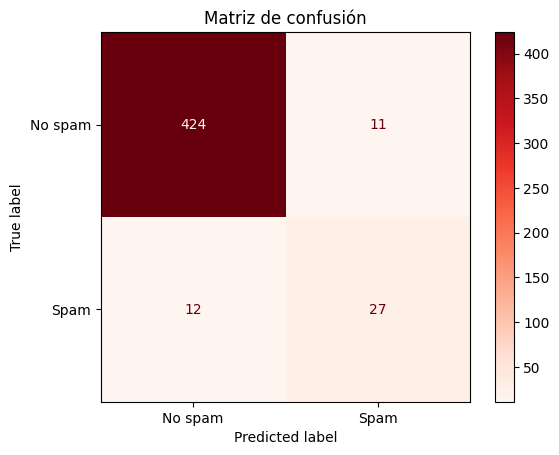

In [21]:
y_pred2 = model2.predict(X_test)

cm2 = confusion_matrix(y_test, y_pred2)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=['No spam', 'Spam'])
disp2.plot(cmap = 'Reds')
plt.title("Matriz de confusión")
print(classification_report(y_test, y_pred2))

Este segundo modelo regularizado detecta más spam real

Aunque el accuracy es elevada en ambos modelos entrenados, es debido a que las clases están muy desbalanceadas. Este segundo modelo ha conseguido una detección de spam real del 69 %


In [22]:
# Guardar el modelo
with open("../models/SVM_regularizado.sav", "wb") as f:
    pickle.dump(model2, f)